In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from keras.metrics import MAE

In [3]:
def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

In [4]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

In [5]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf(x, lag=40):
    """
    Determine autocorrelation factors.
    :param x: (array) Time series.
    :param lag: (int) Number of lags.
    """
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

In [6]:
def bartletts_formula(acf_array, n):
    """
    Computes the Standard Error of an acf with Bartlet's formula
    Read more at: https://en.wikipedia.org/wiki/Correlogram
    :param acf_array: (array) Containing autocorrelation factors
    :param n: (int) Length of original time series sequence.
    """
    # The first value has autocorrelation with it self. So that values is skipped
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n )
    return se


def plot_acf(x, alpha=0.05, lag=40):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    acf_val = acf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

In [7]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1] 
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

In [8]:
def least_squares(x, y):
    return np.linalg.inv((x.T @ x)) @ (x.T @ y)

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None
    
    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x
    
    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta
        
    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

In [9]:
def pacf(x, lag=40):
    """
    Partial autocorrelation function.
    
    pacf results in:
        [1, acf_lag_1, pacf_lag_2, pacf_lag_3]
    :param x: (array)
    :param lag: (int)
    """
    y = []
    
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag + 2):
        backshifted = lag_view(x, i)[0]

        xt = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

        xt_k = backshifted[:, -1]
        xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
    return np.array([1, acf(x, 2)[1]] +  y)

def plot_pacf(x, alpha=0.05, lag=40, title=None):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    pacf_val = pacf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

In [10]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)

In [11]:
class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [14]:
data = pd.read_csv('./data/daily.csv')
data.head()

,Day,Price
0,19970107,3.82
1,19970108,3.80
2,19970109,3.61
3,19970110,3.92
4,19970113,4.00


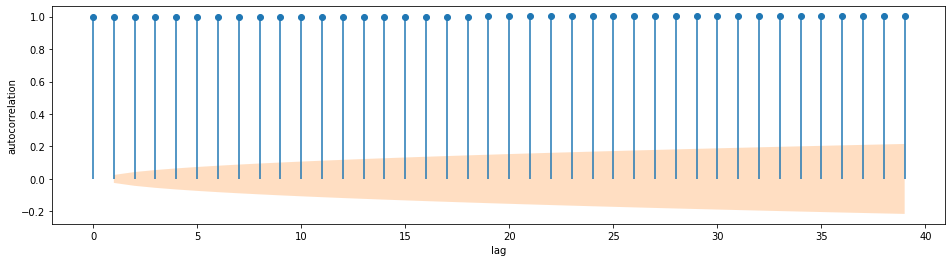

In [31]:
plot_acf(data.Price)

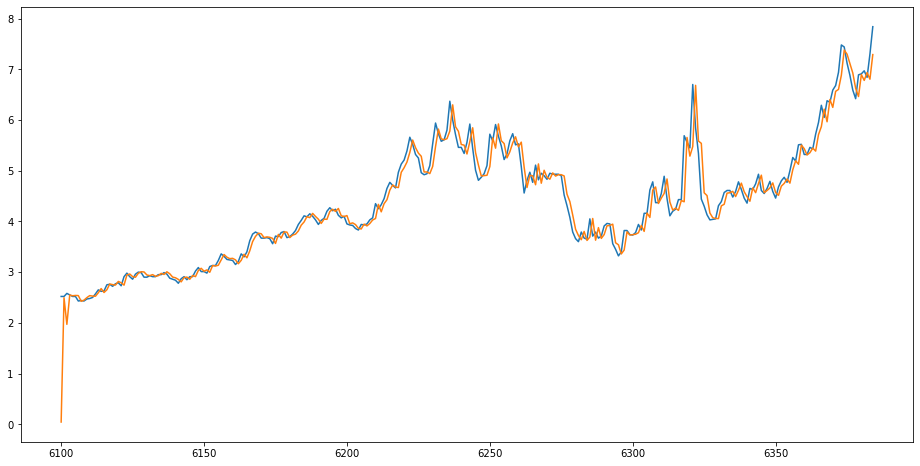

In [15]:
q = 1
d = 0
p = 3

y = data.Price[:6100]
data.reset_index(inplace = True)
x = data.Price[6100:]
m = ARIMA(q, d, p)
m.fit(y)

pred = m.predict(x)

plt.figure(figsize=(16, 8))
res = pd.DataFrame(data={'Actual': x, 'Prediction': pred})
plt.plot(res)
plt.show()

In [37]:
res.head()

,Actual,Prediction
6102,2.58,0.043323
6103,2.55,2.553246
6104,2.52,1.986901
6105,2.52,2.496404
6106,2.43,2.522909


In [38]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [40]:
(smape(x[3:], pred[3:]), MAE(x[3:], pred[3:]))

(3.203267888287358,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.14919213549814733>)